In [295]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [296]:
data = pd.read_csv('./../../../communal/Ames_Housing_Price_Data_cleaned_3.csv')

In [297]:
data = data.drop(['PID','Prop_Addr','mean_LotFrontage'],axis = 1)
predict = data['SalePrice']
log_predict = np.log(predict)
data.drop(['SalePrice','lot_bucket','lat','long','GarageYrBlt'],axis = 1, inplace = True)
dummy = pd.get_dummies(data,drop_first = True)

In [298]:
data['PPSF'] = predict/data.GrLivArea

<AxesSubplot:>

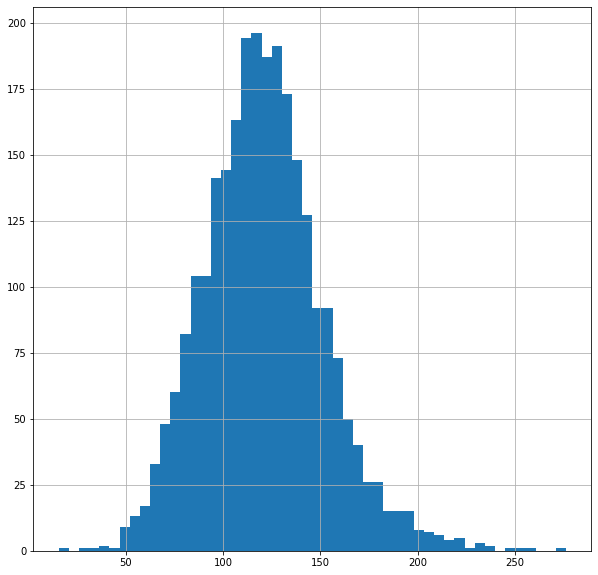

In [226]:
data['PPSF'].hist(bins = 50)

In [41]:
import sklearn
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


#Split dummy data
X_train, X_test, y_train, y_test = train_test_split(dummy, log_predict, train_size= .3)


#Fit and transform X_train with minmaxscaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Make grid search object
gs = GridSearchCV(Lasso(max_iter = 200000), {'alpha' : np.linspace(1e-4,.002,100)} )

gs.fit(X_train, y_train)


GridSearchCV(estimator=Lasso(max_iter=200000),
             param_grid={'alpha': array([0.0001    , 0.00011919, 0.00013838, 0.00015758, 0.00017677,
       0.00019596, 0.00021515, 0.00023434, 0.00025354, 0.00027273,
       0.00029192, 0.00031111, 0.0003303 , 0.00034949, 0.00036869,
       0.00038788, 0.00040707, 0.00042626, 0.00044545, 0.00046465,
       0.00048384, 0.00050303, 0.00052222, 0.00054141, 0.00056061,
       0.00057...
       0.00134747, 0.00136667, 0.00138586, 0.00140505, 0.00142424,
       0.00144343, 0.00146263, 0.00148182, 0.00150101, 0.0015202 ,
       0.00153939, 0.00155859, 0.00157778, 0.00159697, 0.00161616,
       0.00163535, 0.00165455, 0.00167374, 0.00169293, 0.00171212,
       0.00173131, 0.00175051, 0.0017697 , 0.00178889, 0.00180808,
       0.00182727, 0.00184646, 0.00186566, 0.00188485, 0.00190404,
       0.00192323, 0.00194242, 0.00196162, 0.00198081, 0.002     ])})

In [42]:
best_estimator = gs.best_estimator_
best_estimator.score(X_test, y_test)

0.9077263833512954

In [43]:
coefs = pd.Series(best_estimator.coef_, index = dummy.columns)


In [52]:
big_mag = coefs.sort_values(key = abs, ascending = False).index

In [58]:
from sklearn.linear_model import LinearRegression
def calc_vif(data):
    vif = {}
    for feature in data.columns:
        X = [f for f in data.columns if f != feature]
        X = data[X]
        y = data[feature]
        r2 = LinearRegression().fit(X,y).score(X,y)
        vif[feature] = 1/(1-r2)
    return pd.DataFrame.from_dict([vif]).T.sort_values(ascending = False, by = 0)

In [92]:
calc_vif(dummy[big_mag[:15]])

,0
GrLivArea,4.302076
TotRmsAbvGrd,3.151746
OverallQual,2.615046
TotalBsmtSF,1.961764
GarageCars,1.761125
YearRemodAdd,1.534970
BsmtFinSF1,1.453416
Fireplaces,1.417807
Neighborhood_NridgHt,1.237630
OverallCond,1.130327


GrLivArea is still highly correlatedwith something, probably TotRmsAbvGrd, lets drop one and see whats good

In [62]:
big_mag_without_rms_abv_grd = big_mag.drop('TotRmsAbvGrd')

In [91]:
calc_vif(dummy[big_mag_without_rms_abv_grd[:15]])

,0
OverallQual,2.590316
BsmtFinSF1,2.089448
TotalBsmtSF,1.962499
GrLivArea,1.793365
GarageCars,1.761046
BsmtFullBath,1.700697
YearRemodAdd,1.542579
Fireplaces,1.408173
Neighborhood_NridgHt,1.230834
OverallCond,1.131262


Lets rerun our grid search with our new list

In [78]:
import sklearn
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


#Split dummy data
X_train, X_test, y_train, y_test = train_test_split(dummy[big_mag_without_rms_abv_grd[:9]], log_predict, train_size= .3)


#Fit and transform X_train with minmaxscaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Make grid search object
gs = GridSearchCV(Lasso(max_iter = 200000), {'alpha' : np.linspace(1e-4,.002,100)} )

#Fit and do grid search
gs.fit(X_train, y_train)

#Test on test data
best_estimator = gs.best_estimator_
best_estimator.score(X_test,y_test)

0.8311771192664424

Now we will try without GrLivArea

In [79]:
big_mag_without_grLvArea = big_mag.drop('GrLivArea')

In [106]:
import sklearn
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


#Split dummy data
X_train, X_test, y_train, y_test = train_test_split(dummy[big_mag], log_predict, train_size= .3)


#Fit and transform X_train with minmaxscaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Make grid search object
gs = GridSearchCV(Lasso(max_iter = 200000), {'alpha' : np.linspace(1e-4,.002,100)} )

#Fit and do grid search
gs.fit(X_train, y_train)

#Test on test data
best_estimator = gs.best_estimator_
best_estimator.score(X_test,y_test)

0.9094564114152831

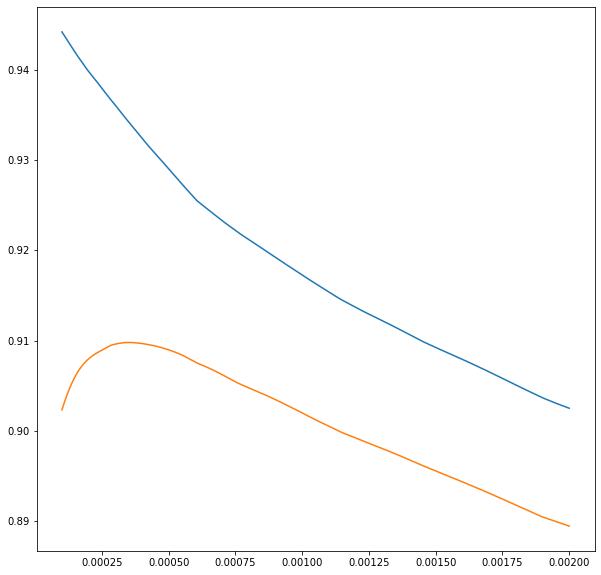

In [108]:
trainR2 = []
testR2 = []
alphas = np.linspace(1e-4,.002, 200)
lasso.set_params(max_iter = 2_000_000)
for alpha in alphas:
    lasso.set_params(alpha = alpha)
    lasso.fit(X_train, y_train)
    trainR2.append(lasso.score(X_train, y_train))
    testR2.append(lasso.score(X_test, y_test))
    
plt.plot(alphas,trainR2,label = 'trainR2')
plt.plot(alphas,testR2,label = 'testR2')
    



<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

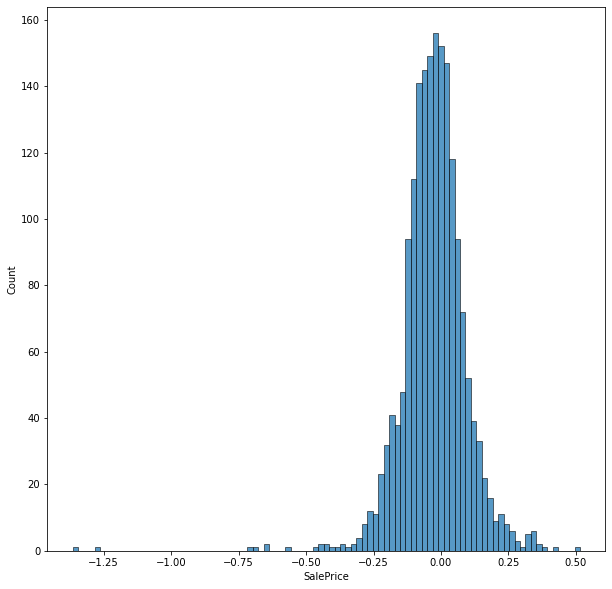

In [261]:
np.argmax(testR2)
lasso.set_params(alpha = alphas[np.argmax(testR2)])
residualsSquared = sum((y_test - lasso.predict(X_test))**2)
residualsSquared
sns.histplot((y_test - lasso.predict(X_test)))

In [119]:
pd.Series(lasso.coef_, index = dummy.columns).sort_values(key = abs, ascending = False)

GrLivArea               0.704304
MSSubClass              0.604323
LotArea                 0.263795
LotFrontage             0.132828
OverallQual             0.119824
BsmtFinSF2              0.105364
BsmtUnfSF               0.099403
HalfBath                0.089261
YearRemodAdd            0.084267
GarageYrBlt_1982.0     -0.070592
GarageYrBlt_1972.0      0.068302
GarageCars              0.066616
FullBath                0.055967
BedroomAbvGr            0.053605
Fireplaces              0.050570
1stFlrSF                0.049575
Neighborhood_Gilbert   -0.045697
GarageArea              0.045437
2ndFlrSF               -0.041503
YrSold                 -0.037042
LotShape_IR2            0.035983
MoSold                 -0.035020
TotRmsAbvGrd            0.033813
LowQualFinSF            0.033444
Neighborhood_NoRidge    0.032758
TotalPorchSF           -0.027797
MSZoning_FV             0.023928
Neighborhood_Crawfor   -0.023420
Neighborhood_Sawyer    -0.022454
Neighborhood_BrkSide   -0.018600
GarageYrBl

In [82]:
calc_vif(dummy[big_mag_without_grLvArea[:9]])

,0
OverallQual,1.916896
GarageCars,1.673394
TotalBsmtSF,1.500282
Fireplaces,1.260591
TotRmsAbvGrd,1.241604
OverallCond,1.087058
ExterCond_Fa,1.062700
MSZoning_C (all),1.023938
GarageYrBlt_1928.0,1.005922


<AxesSubplot:>

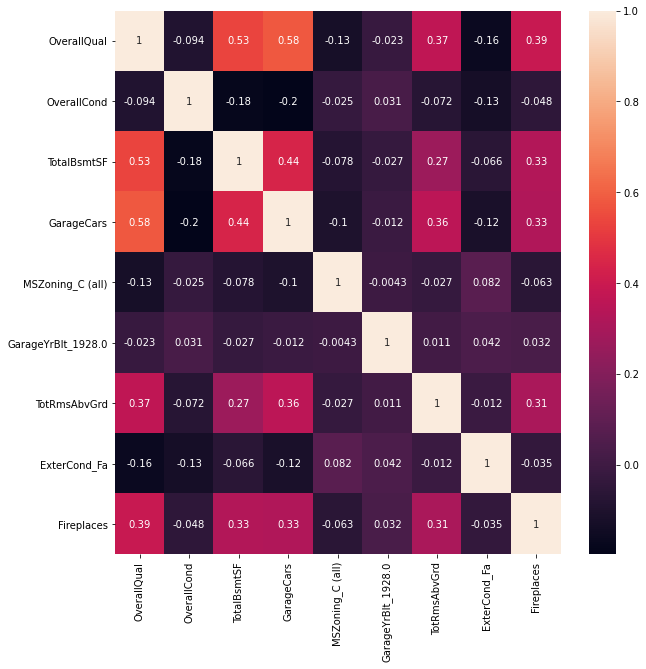

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
sns.heatmap(dummy[big_mag_without_grLvArea[:9]].corr(), annot = True)

In [122]:
data.head()

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,MoSold,YrSold,TotalPorchSF
0,856,30,RL,64.9,7890,Reg,SWISU,1Fam,1Story,6,6,1939,1950,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,0.0,618.0,856.0,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,TA,4,1,Gd,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,3,2010,166
1,1049,120,RL,42.0,4235,Reg,Edwards,TwnhsE,1Story,5,5,1984,1984,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,393.0,104.0,1049.0,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,Gd,5,0,None,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,2,2009,105
2,1049,120,RL,42.0,4235,Reg,Edwards,TwnhsE,1Story,5,5,1984,1984,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,393.0,104.0,1049.0,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,Gd,5,0,None,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,2,2009,105
3,1001,30,C (all),60.0,6060,Reg,IDOTRR,1Fam,1Story,5,9,1930,2007,MetalSd,None,0.0,Gd,TA,BrkTil,TA,TA,No,ALQ,737.0,0.0,100.0,837.0,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,Gd,5,0,None,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,11,2007,128
4,1039,70,RL,80.0,8146,Reg,OldTown,1Fam,2Story,4,8,1900,2003,MetalSd,None,0.0,Gd,Gd,BrkTil,Fa,TA,No,Unf,0.0,0.0,405.0,405.0,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,TA,6,0,None,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,5,2009,279


In [123]:
import statsmodels.api as sm

dummy_with_constant = sm.add_constant(dummy)

In [124]:
model = sm.OLS(log_predict,dummy_with_constant).fit()

In [140]:
np.set_printoptions(suppress = True)
influence = model.get_influence()
cooks = influence.cooks_distance
print(cooks)

(array([0.00000416, 0.00041196, 0.00041196, ..., 0.00043904, 0.00001738,
       0.00000116]), array([1., 1., 1., ..., 1., 1., 1.]))


/Users/charlesphillips/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


In [159]:
outliers = []
for i in range(len(cooks[0])):
    if cooks[1][i] < .05:
        print(cooks[0][i], cooks[1][i], i)
        outliers.append(i)

15333.076122776743 0.0 115
26.710137521426603 0.0 132
27589.119508426862 0.0 141
14.712775983854874 0.0 335
1.643994100402425 3.1083588860746777e-09 490
8.852073595903638 9.433942730846788e-210 538
5.34192636863567 3.382742404391732e-113 2047
26.261520077852534 0.0 2239


In [160]:
data.iloc[outliers]

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,MoSold,YrSold,TotalPorchSF
115,1224,50,RL,72.0,10632,IR1,ClearCr,1Fam,1.5Fin,5,3,1917,1950,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,0.0,689.0,689.0,Gd,N,SBrkr,725,499,0,0.0,0.0,1,1,3,Po,6,0,None,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,1,2010,248
132,1049,50,C (all),52.0,5150,Reg,IDOTRR,1Fam,1.5Fin,4,7,1910,2000,Plywood,None,0.0,TA,TA,PConc,Po,TA,No,Unf,0.0,0.0,356.0,356.0,TA,N,FuseA,671,378,0,0.0,0.0,1,0,2,TA,5,0,None,Detchd,1910.0,Unf,1.0,195.0,Po,Fa,N,0,5,2008,0
141,1827,70,RL,69.0,11737,IR1,BrkSide,1Fam,2Story,6,7,1924,1996,BrkComm,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,0.0,848.0,848.0,TA,N,SBrkr,1017,810,0,0.0,0.0,1,0,2,TA,9,1,Gd,Detchd,1943.0,Unf,1.0,240.0,Fa,TA,Y,27,5,2006,78
335,2358,50,RL,75.0,45600,IR2,ClearCr,1Fam,1.5Fin,6,8,1908,1997,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,0.0,907.0,907.0,TA,Y,SBrkr,1307,1051,0,0.0,0.0,3,0,5,TA,10,1,Gd,Detchd,1908.0,Unf,2.0,360.0,Fa,TA,Y,486,9,2008,215
490,1288,70,RM,60.0,3600,Reg,OldTown,1Fam,2Story,6,7,1917,2007,Stucco,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,0.0,624.0,624.0,Ex,Y,SBrkr,664,624,0,1.0,0.0,1,0,3,Ex,5,1,Gd,Attchd,1917.0,Unf,1.0,280.0,TA,TA,N,0,5,2009,103
538,1984,60,RM,57.0,8094,Reg,OldTown,2fmCon,2.5Unf,6,8,1910,1983,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,0.0,1046.0,1242.0,Gd,Y,SBrkr,1242,742,0,0.0,0.0,2,0,5,TA,8,0,None,Detchd,None,None,1.0,360.0,None,None,Y,64,9,2008,180
2047,1361,70,C (all),60.0,5280,Reg,IDOTRR,1Fam,2Story,4,7,1895,1950,Wd Sdng,None,0.0,TA,TA,Stone,Po,Fa,No,Unf,0.0,0.0,173.0,173.0,Ex,N,SBrkr,825,536,0,0.0,0.0,1,0,2,TA,6,0,None,Detchd,1895.0,Unf,1.0,185.0,Fa,TA,Y,0,7,2008,123
2239,1600,20,A (agr),125.0,31250,Reg,Mitchel,1Fam,1Story,1,3,1951,1951,CBlock,None,0.0,TA,Fa,CBlock,None,None,None,None,0.0,0.0,0.0,0.0,TA,Y,FuseA,1600,0,0,0.0,0.0,1,1,3,TA,6,0,None,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,5,2006,135


In [153]:
predict[115]

107500

In [161]:
outliers

[115, 132, 141, 335, 490, 538, 2047, 2239]

# Dropping outliers and rerunning lasso to see if our R^2 is better

In [299]:
dropped_outliers = data.drop(outliers)
dropped_outliers_log_predict = log_predict.drop(outliers)
dropped_outliers_dummy = pd.get_dummies(dropped_outliers, drop_first = True)

In [306]:
import sklearn
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


#Split dummy data
X_train, X_test, y_train, y_test = train_test_split(dropped_outliers_dummy, dropped_outliers_log_predict, train_size= .3)


#Fit and transform X_train with minmaxscaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Make grid search object
gs = GridSearchCV(Lasso(max_iter = 2000000), {'alpha' : np.linspace(1e-4,.002,200)} )

#Fit and do grid search
gs.fit(X_train, y_train)

#Test on test data
best_estimator = gs.best_estimator_
best_estimator.score(X_test,y_test)

0.904411741807435

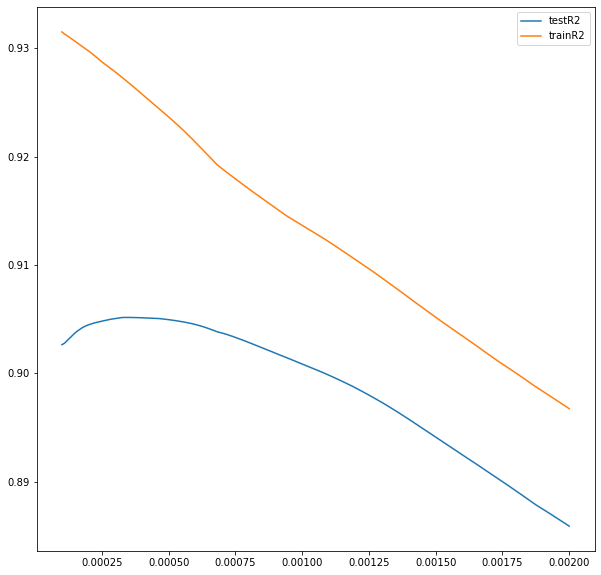

In [307]:
lasso = Lasso()
lasso.set_params(max_iter = 2_000_000)
testR2 = []
trainR2 = []
coefs = []
alphas = np.linspace(1e-4,.002,200)
for alpha in alphas:
    lasso.set_params(alpha = alpha)
    lasso.fit(X_train, y_train)
    trainR2.append(lasso.score(X_train, y_train))
    testR2.append(lasso.score(X_test, y_test))
    coefs.append(lasso.coef_)

plt.plot(alphas,testR2,label = 'testR2')
plt.plot(alphas,trainR2,label = 'trainR2')
plt.legend()
    

In [214]:
for name in dummy.columns:
    plt.plot(alphas, c[name], label=name)
    
plt.legend(loc=1)    
plt.title('Change of Lasso Slopes Varying Alpha')

IndexError: invalid index to scalar variable.

In [215]:
best_alpha = alphas[np.argmax(testR2)]
lasso.set_params(alpha = best_alpha)

Lasso(alpha=0.00048190954773869347, max_iter=2000000)

In [216]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.00048190954773869347, max_iter=2000000)

In [220]:
lists = pd.Series(lasso.coef_, index = dropped_outliers_dummy.columns).sort_values(key = abs,ascending = False)
lists

GrLivArea               0.691725
OverallQual             0.537076
OverallCond             0.336512
ExterCond_Fa           -0.175277
TotalBsmtSF             0.172619
TotRmsAbvGrd            0.147269
GarageCars              0.145610
Neighborhood_Crawfor    0.130991
Neighborhood_GrnHill    0.126158
1stFlrSF                0.125341
YearBuilt               0.115131
Neighborhood_StoneBr    0.114741
Fireplaces              0.108322
Neighborhood_Somerst    0.096364
BldgType_Twnhs         -0.094722
BsmtFinSF1              0.094062
BldgType_Duplex        -0.087702
Neighborhood_NridgHt    0.084430
Neighborhood_NoRidge    0.068840
BsmtFullBath            0.068370
MSZoning_RL             0.064496
Neighborhood_ClearCr    0.063393
BsmtFinSF2              0.062648
YearRemodAdd            0.058840
KitchenQual_TA         -0.058577
Neighborhood_Timber     0.058433
PavedDrive_Y            0.057458
GarageCond_Fa          -0.055214
CentralAir_Y            0.053890
Neighborhood_IDOTRR    -0.052569
Neighborho

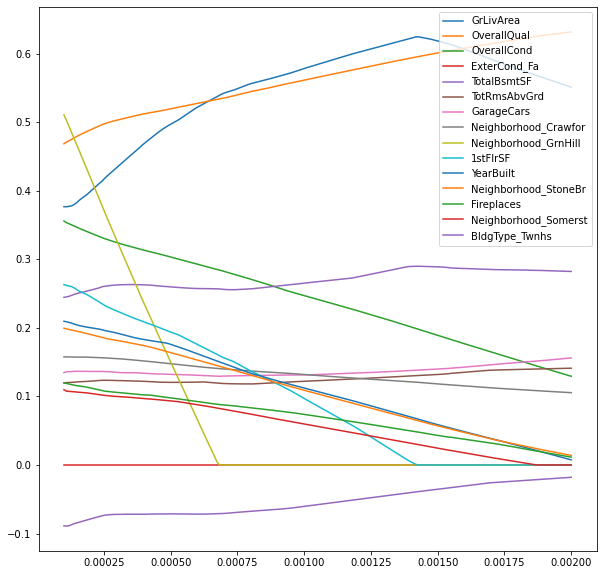

In [308]:
coef_df = pd.DataFrame(coefs, columns = dropped_outliers_dummy.columns)
for f in lists[:15].index:
    plt.plot(alphas, coef_df[f],label = f)
plt.legend(loc=1)

In [309]:
lists

GrLivArea               0.691725
OverallQual             0.537076
OverallCond             0.336512
ExterCond_Fa           -0.175277
TotalBsmtSF             0.172619
TotRmsAbvGrd            0.147269
GarageCars              0.145610
Neighborhood_Crawfor    0.130991
Neighborhood_GrnHill    0.126158
1stFlrSF                0.125341
YearBuilt               0.115131
Neighborhood_StoneBr    0.114741
Fireplaces              0.108322
Neighborhood_Somerst    0.096364
BldgType_Twnhs         -0.094722
BsmtFinSF1              0.094062
BldgType_Duplex        -0.087702
Neighborhood_NridgHt    0.084430
Neighborhood_NoRidge    0.068840
BsmtFullBath            0.068370
MSZoning_RL             0.064496
Neighborhood_ClearCr    0.063393
BsmtFinSF2              0.062648
YearRemodAdd            0.058840
KitchenQual_TA         -0.058577
Neighborhood_Timber     0.058433
PavedDrive_Y            0.057458
GarageCond_Fa          -0.055214
CentralAir_Y            0.053890
Neighborhood_IDOTRR    -0.052569
Neighborho

In [186]:
coefs.sort_values(key = abs, ascending = False)

GrLivArea               0.687657
OverallQual             0.539683
OverallCond             0.247253
TotalBsmtSF             0.235620
GarageCars              0.190694
MSZoning_C (all)       -0.169853
GarageYrBlt_1928.0     -0.153929
TotRmsAbvGrd            0.149150
ExterCond_Fa           -0.124134
Fireplaces              0.107390
BsmtFinSF1              0.097196
YearRemodAdd            0.090761
Neighborhood_StoneBr    0.083949
Neighborhood_NridgHt    0.083853
BldgType_Twnhs         -0.075148
BsmtFullBath            0.072623
YearBuilt               0.070250
BsmtQual_Fa            -0.064751
Neighborhood_Crawfor    0.064383
CentralAir_Y            0.063406
MSZoning_RL             0.063347
Foundation_PConc        0.061120
BsmtExposure_Gd         0.059564
Neighborhood_Somerst    0.051334
1stFlrSF                0.049863
GarageCond_Fa          -0.045087
BsmtFinType1_Unf       -0.033415
KitchenQual_TA         -0.032457
Neighborhood_Edwards   -0.030973
YrSold                 -0.030660
PavedDrive

In [302]:
dropped_outliers_dummy['ratio_second_to_first']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.449093
5       1.055556
6       2.882828
7       0.000000
8       0.000000
9       0.000000
10      0.000000
11      0.000000
12      1.041667
13      0.000000
14      0.000000
15      0.000000
16      0.896163
17      0.000000
18      0.000000
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      1.000000
24      1.000000
25      1.080000
26      1.398026
27      0.000000
28      1.045514
29      0.887986
30      0.000000
31      0.000000
32      0.000000
33      0.000000
34      0.754986
35      0.000000
36      0.000000
37      1.043224
38      0.000000
39      0.000000
40      0.815742
41      0.000000
42      0.000000
43      0.416830
44      0.000000
45      0.000000
46      0.000000
47      0.000000
48      0.000000
49      1.042610
50      1.051813
51      1.312869
52      0.494774
53      0.000000
54      0.803519
55      1.000000
56      0.000000
57      0.638596
58      0.0000

# Lets predict ppsf, see how it does

In [300]:
data.drop(outliers, inplace = True)
ppsf = data['PPSF']
data.drop('PPSF', inplace = True,axis = 1)
dropped_outliers_dummy = pd.get_dummies(data, drop_first = True)
dropped_outliers_dummy['ratio_second_to_first'] = dropped_outliers_dummy['2ndFlrSF']/dropped_outliers_dummy['1stFlrSF']

import sklearn
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV




#Split dummy data
X_train, X_test, y_train, y_test = train_test_split(dropped_outliers_dummy, dropped_outliers_log_predict, train_size= .3)


#Fit and transform X_train with minmaxscaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Make grid search object
gs = GridSearchCV(Lasso(max_iter = 2_000_000), {'alpha' : np.linspace(1e-4,.002,200)} )

#Fit and do grid search
gs.fit(X_train, y_train)

#Test on test data
best_estimator = gs.best_estimator_
best_estimator.score(X_test,y_test)


0.9061476573699283

In [286]:
print(dropped_outliers_dummy.columns.sort_values())

Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BldgType_2fmCon',
       'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtCond_Fa',
       'BsmtCond_Gd', 'BsmtCond_None',
       ...
       'OverallQual', 'PavedDrive_P', 'PavedDrive_Y', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'TotalPorchSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object', length=160)


In [282]:
def run_lasso(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= .3)


    #Fit and transform X_train with minmaxscaler
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    #Make grid search object
    gs = GridSearchCV(Lasso(max_iter = 2_000_000), {'alpha' : np.linspace(1e-4,.0015,250)} )

    #Fit and do grid search
    gs.fit(X_train, y_train)

    #Test on test data
    best_estimator = gs.best_estimator_
    return best_estimator.score(X_test,y_test)



In [301]:
l = pd.Series(best_estimator.coef_, index = dropped_outliers_dummy.columns)
l = l.sort_values(key = abs, ascending = False)
l[:60]

GrLivArea                0.755184
OverallQual              0.431111
OverallCond              0.376401
Neighborhood_GrnHill     0.319005
TotalBsmtSF              0.310501
YearBuilt                0.215473
BsmtFinSF1               0.159523
GarageCars               0.131823
KitchenQual_Fa          -0.103709
Neighborhood_StoneBr     0.100632
Neighborhood_ClearCr     0.092955
Exterior1st_PreCast      0.092672
BldgType_Duplex         -0.081312
GarageArea               0.078818
Neighborhood_Crawfor     0.074634
1stFlrSF                 0.074393
CentralAir_Y             0.066383
Exterior1st_Stucco       0.063222
KitchenQual_TA          -0.062069
MSZoning_RM             -0.059031
Neighborhood_Timber      0.055096
MSZoning_FV              0.054777
GarageCond_Fa           -0.053723
Exterior1st_BrkFace      0.052077
BsmtExposure_Gd          0.051594
ratio_second_to_first    0.050617
BldgType_Twnhs          -0.048893
Neighborhood_Somerst     0.048506
YearRemodAdd             0.047890
Neighborhood_N

In [277]:
calc_vif(dropped_outliers_dummy[l[:15].index])

,0
YearBuilt,5.427966
MSZoning_FV,5.101936
Neighborhood_Somerst,4.945165
GrLivArea,3.841046
OverallQual,3.316372
TotalBsmtSF,2.751356
Foundation_PConc,2.639959
BsmtFinSF1,2.469566
FullBath,2.454406
YearRemodAdd,2.400333


In [259]:
l =l.drop('GarageCars')

In [283]:
for i in range(1,50):
    print(i, run_lasso(dropped_outliers_dummy[l[:i].index],log_predict.drop(outliers)))

1 0.5092522093544085
2 0.7658303192288972
3 0.7615286753229571
4 0.8096477822424389
5 0.828811443556666
6 0.8774801983845354
7 0.8756476111974323
8 0.8810847146438862
9 0.8975655971535292
10 0.8860467586459263
11 0.8833766892675066
12 0.8842190818352132
13 0.8886246020677091
14 0.8883195129379376
15 0.8978659615866798
16 0.8953128858570661
17 0.8895580318287
18 0.8906252871047956
19 0.8990731624714601
20 0.9104000813324904
21 0.9022360522532767
22 0.9065029226326358
23 0.896541609337447
24 0.9087451328196873
25 0.8996308519046965
26 0.9047197532854889
27 0.9225687125567753
28 0.9082751425624233
29 0.9189995331223083
30 0.9133575949555343
31 0.9134232375597553
32 0.9100607074176612
33 0.9051697738455682
34 0.9154515485837139
35 0.90239330254916
36 0.9056467252132118
37 0.9122916731237158
38 0.9152945371920205
39 0.9082807673522104
40 0.9088730880128444
41 0.9098692654012187
42 0.909449842411098
43 0.9021828259330351
44 0.908697282635703
45 0.9215074900398429
46 0.9165907045383773
47 0.9

In [271]:
data.filter(regex = 'Bsmt')

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,TA,TA,No,Rec,238.0,0.0,618.0,856.0,1.0,0.0
1,Gd,TA,Mn,GLQ,552.0,393.0,104.0,1049.0,1.0,0.0
2,Gd,TA,Mn,GLQ,552.0,393.0,104.0,1049.0,1.0,0.0
3,TA,TA,No,ALQ,737.0,0.0,100.0,837.0,0.0,0.0
4,Fa,TA,No,Unf,0.0,0.0,405.0,405.0,0.0,0.0
5,Gd,TA,No,GLQ,643.0,0.0,167.0,810.0,1.0,0.0
6,None,None,None,None,0.0,0.0,0.0,0.0,0.0,0.0
7,Fa,TA,No,Unf,0.0,0.0,936.0,936.0,0.0,0.0
8,Gd,TA,Gd,Unf,0.0,0.0,1146.0,1146.0,0.0,0.0
9,TA,TA,No,ALQ,647.0,0.0,217.0,864.0,0.0,0.0


In [276]:
data[['TotalBsmtSF', 'BsmtFinSF1']].corr()

,TotalBsmtSF,BsmtFinSF1
TotalBsmtSF,1.000000,0.515614
BsmtFinSF1,0.515614,1.000000
